## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    !pip install pytorch-tcn
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()
from IPython.display import clear_output
from torch.optim.lr_scheduler import ExponentialLR

In [2]:

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from Utils.Merge_data import get_data



# Network

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:



# Step 1: Prepare the Data
df = get_data('./data')
df.drop(columns=['Time(UTC+0)'], inplace=True)
# Split into features (X) and target variable (y)
X = df.drop(columns=['PM2.5(μm/m^3)']).values
y = df['PM2.5(μm/m^3)'].values.reshape(-1, 1)

# Normalize the data
scaler_x = MinMaxScaler()
X = scaler_x.fit_transform(X)
scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y)

# Step 2: Create Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = CustomDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Step 3: Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Use only the last timestep's output
        return out

# Step 4: Train the Model
input_size = X.shape[1]
hidden_size = 256
num_layers = 5
output_size = 1
num_epochs = 100
learning_rate = 0.001

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        # Reshape inputs to add batch dimension
        inputs = inputs.unsqueeze(1)  # Add batch dimension
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0305
Epoch [2/100], Loss: 0.0291
Epoch [3/100], Loss: 0.0081
Epoch [4/100], Loss: 0.0156
Epoch [5/100], Loss: 0.0087
Epoch [6/100], Loss: 0.0125
Epoch [7/100], Loss: 0.0035
Epoch [8/100], Loss: 0.0179
Epoch [9/100], Loss: 0.0103
Epoch [10/100], Loss: 0.0114
Epoch [11/100], Loss: 0.0088
Epoch [12/100], Loss: 0.0074
Epoch [13/100], Loss: 0.0100
Epoch [14/100], Loss: 0.0132
Epoch [15/100], Loss: 0.0096
Epoch [16/100], Loss: 0.0268
Epoch [17/100], Loss: 0.0108
Epoch [18/100], Loss: 0.0142
Epoch [19/100], Loss: 0.0185
Epoch [20/100], Loss: 0.0064
Epoch [21/100], Loss: 0.0069
Epoch [22/100], Loss: 0.0225
Epoch [23/100], Loss: 0.0215
Epoch [24/100], Loss: 0.0259
Epoch [25/100], Loss: 0.0187
Epoch [26/100], Loss: 0.0174
Epoch [27/100], Loss: 0.0074
Epoch [28/100], Loss: 0.0074
Epoch [29/100], Loss: 0.0102
Epoch [30/100], Loss: 0.0062
Epoch [31/100], Loss: 0.0044
Epoch [32/100], Loss: 0.0259
Epoch [33/100], Loss: 0.0178
Epoch [34/100], Loss: 0.0177
Epoch [35/100], Loss: 0

<Figure size 1500x500 with 0 Axes>

In [11]:
# Load the dataset
df_descale = get_data('./data')

# Calculate min and max for scaling
min_P = df_descale['PM2.5(μm/m^3)'].min()
max_P = df_descale['PM2.5(μm/m^3)'].max()

# Print min and max for verification
print("Minimum PM2.5(μm/m^3):", min_P)
print("Maximum PM2.5(μm/m^3):", max_P)

Minimum PM2.5(μm/m^3): 1.57
Maximum PM2.5(μm/m^3): 131.0


<Figure size 1500x500 with 0 Axes>

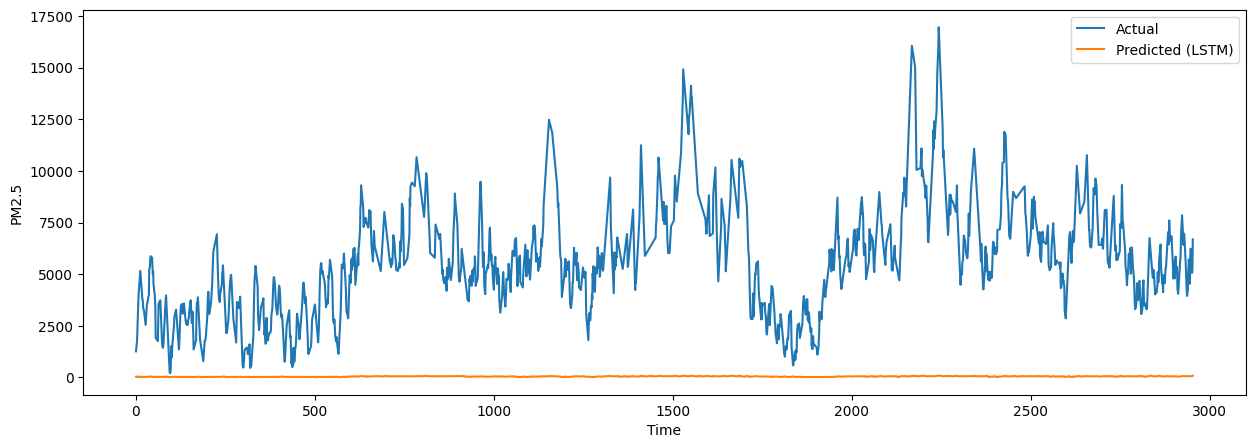

In [12]:
# Move the model to the same device as the input data
model.to(device)

# Generate predictions on the entire dataset in order
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)
all_predictions_lstm = []
model.eval()
with torch.no_grad():
    for inputs, _ in all_loader:
        inputs = inputs.to(device)
        outputs = model(inputs.unsqueeze(0))  # Add batch dimension
        all_predictions_lstm.append(outputs.item())

# Convert predictions to numpy array
all_predictions_lstm = np.array(all_predictions_lstm)
# Descale predictions
descaled_all_predictions_lstm = all_predictions_lstm * (max_P - min_P) + min_P
descaled_actual_values = df['PM2.5(μm/m^3)'].values[:] * (max_P - min_P) + min_P

# Plot actual vs predicted for LSTM model
plt.figure(figsize=(15, 5))
plt.plot(descaled_actual_values, label='Actual')
plt.plot(descaled_all_predictions_lstm, label='Predicted (LSTM)')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()
